In [1]:
import torchaudio

def extract_mel_spectrogram_torchaudio(file_path, sr=16000, n_mels=128, duration=None):
    waveform, sample_rate = torchaudio.load(file_path)
    if duration is not None:
        num_samples = int(duration * sample_rate)
        waveform = waveform[:, :num_samples]
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sr)
    waveform = resampler(waveform)
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=n_mels)(waveform)
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
    return mel_spec_db

In [3]:
import torch, torchaudio


def extract_batch_mel_from_path(waveform_path, 
                               cut_audio_duration = None, 
                               sampling_rate=16000, 
                               hop_length=160, 
                               filter_length=1024, 
                               n_mel=64, 
                               mel_fmin=0, 
                               mel_fmax=8000, 
                               win_length=1024):
    waveform, orig_sr = torchaudio.load(waveform_path)
    if cut_audio_duration is None:
        cut_audio_duration = waveform.shape[-1] / orig_sr
        print(cut_audio_duration)
        waveform = waveform[:1]
    if orig_sr != sampling_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=sampling_rate)
        waveform = resampler(waveform)
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    num_samples = int(cut_audio_duration * sampling_rate)
    if waveform.size(1) > num_samples:
        waveform = waveform[:, :num_samples]
    elif waveform.size(1) < num_samples:
        pad_size = num_samples - waveform.size(1)
        waveform = torch.nn.functional.pad(waveform, (0, pad_size))
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sampling_rate,
        n_fft=filter_length,
        win_length=win_length,
        hop_length=hop_length,
        n_mels=n_mel,
        f_min=mel_fmin,
        f_max=mel_fmax
    )
    mel = mel_transform(waveform)
    mel_db = torchaudio.transforms.AmplitudeToDB()(mel)
    return mel_db[0]


mel_db = extract_batch_mel_from_path('/home/chengxin/chengxin/vasflow/test/car_police.mp4')

5.5495691609977325


5.5495691609977325


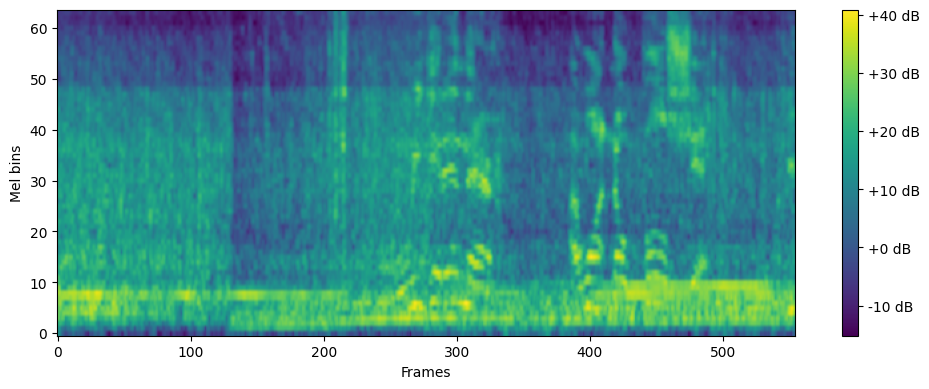

In [7]:
import matplotlib.pyplot as plt

mel_db1 = extract_batch_mel_from_path('/home/chengxin/chengxin/vasflow/test/car_police_.mp4')
plt.figure(figsize=(10, 4))
plt.imshow(mel_db1.numpy(), aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.tight_layout()
plt.show()

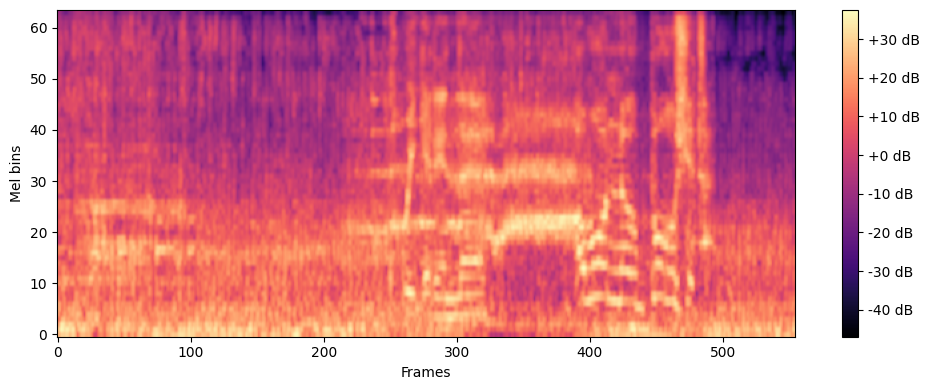

In [3]:
mel_db2 = extract_batch_mel_from_path('/home/chengxin/chengxin/vasflow/test/car_police_05_replace_audio.mp4', cut_audio_duration=5.54)
plt.figure(figsize=(10, 4))
plt.imshow(mel_db2.numpy(), aspect='auto', origin='lower', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.tight_layout()
plt.show()

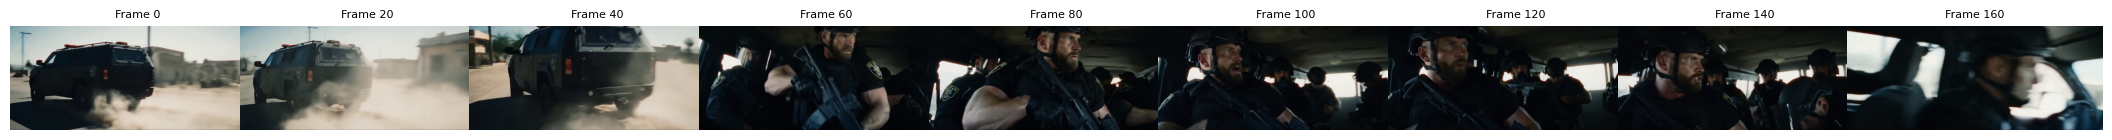

In [12]:
import cv2
import os
from IPython.display import display, Image
import matplotlib.pyplot as plt

def extract_and_display_frames(video_path, output_dir, fps=1, start_frame=0, end_frame=None):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    # Get video properties
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Set end_frame if not provided
    if end_frame is None:
        end_frame = total_frames
    
    # Calculate frame interval based on desired FPS
    frame_interval = int(video_fps / fps) if fps > 0 else 1
    
    # List to store frame paths
    frame_paths = []
    
    # Read and save frames
    current_frame = start_frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    while current_frame < end_frame:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Save frame
        output_path = os.path.join(output_dir, f"frame_{current_frame:06d}.jpg")
        cv2.imwrite(output_path, frame)
        frame_paths.append(output_path)
        
        # Move to next frame based on interval
        current_frame += frame_interval
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
    
    # Release video
    cap.release()
    
    # Display frames horizontally
    display_cols = len(frame_paths)
    plt.figure(figsize=(display_cols * 3, 3))  # Adjusted for tighter horizontal layout
    
    for i, frame_path in enumerate(frame_paths):
        img = plt.imread(frame_path)
        plt.subplot(1, display_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Frame {start_frame + i * frame_interval}", fontsize=8)
    
    plt.subplots_adjust(wspace=-0.1, hspace=0)  # Minimize spacing between frames
    plt.show()


    
# Example usage in Jupyter Notebook
if __name__ == "__main__":
    video_path = "/home/chengxin/chengxin/vasflow/test/car_police_.mp4"
    output_dir = '/home/chengxin/chengxin/vasflow/vis/images'
extract_and_display_frames(video_path, output_dir, fps=1.5, start_frame=0)

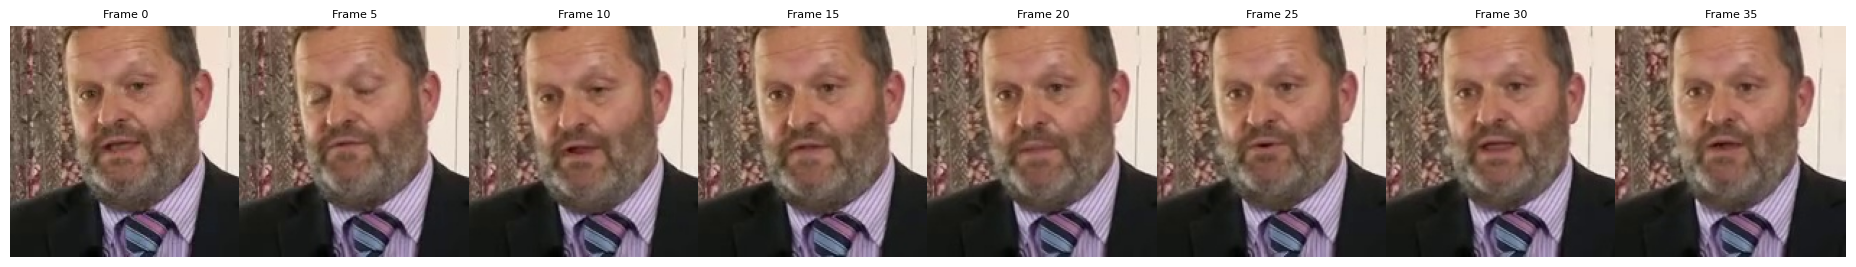

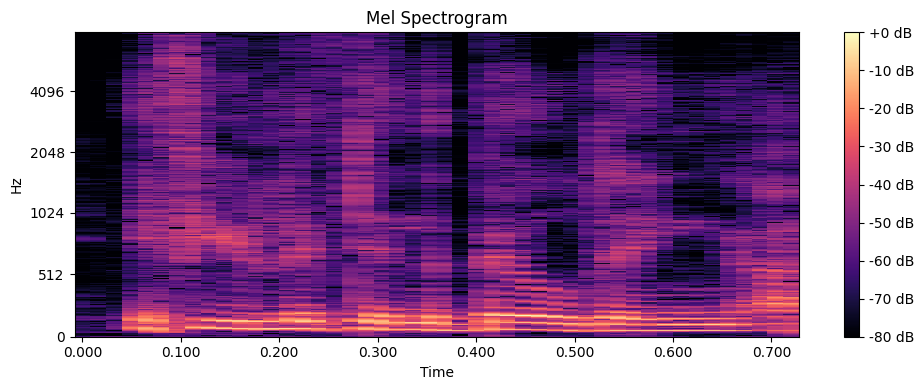

Saved mel spectrogram to mel_librosa.png


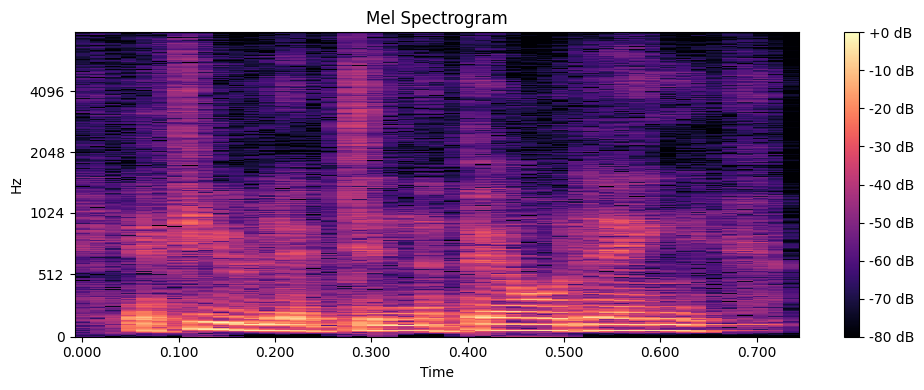

Saved mel spectrogram to mel_librosa.png


'./test.lab'

In [27]:
import cv2
import os
from IPython.display import display, Image
import matplotlib.pyplot as plt

import librosa
import numpy as np
import shutil

def extract_and_display_frames(video_path, output_dir, fps=1, start_frame=0, end_frame=None):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    
    # Get video properties
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Set end_frame if not provided
    if end_frame is None:
        end_frame = total_frames
    
    # Calculate frame interval based on desired FPS
    frame_interval = int(video_fps / fps) if fps > 0 else 1
    
    # List to store frame paths
    frame_paths = []
    
    # Read and save frames
    current_frame = start_frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    while current_frame < end_frame:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Save frame
        output_path = os.path.join(output_dir, f"frame_{current_frame:06d}.jpg")
        cv2.imwrite(output_path, frame)
        frame_paths.append(output_path)
        
        # Move to next frame based on interval
        current_frame += frame_interval
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
    
    # Release video
    cap.release()
    
    # Display frames horizontally
    display_cols = len(frame_paths)
    plt.figure(figsize=(display_cols * 3, 3))  # Adjusted for tighter horizontal layout
    
    for i, frame_path in enumerate(frame_paths):
        img = plt.imread(frame_path)
        plt.subplot(1, display_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Frame {start_frame + i * frame_interval}", fontsize=8)
    
    plt.subplots_adjust(wspace=-0.1, hspace=0)  # Minimize spacing between frames
    plt.show()




def plot_mel_librosa(audio_path, save_path='mel_librosa.png', sr=16000, n_mels=80):
    # 加载音频 
    y, sr = librosa.load(audio_path, sr=sr)
    data = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)


    # 可视化
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(
        data,
        sr=sr,
        hop_length=256,
        x_axis='time',
        y_axis='mel',
        cmap='magma'  # 可改为 'Greens', 'viridis', 'plasma' 等
    )
    plt.colorbar(format='%+2.0f dB')  # 可去掉
    plt.title("Mel Spectrogram")
    plt.tight_layout()
    # plt.savefig(save_path)
    plt.show()
    print(f"Saved mel spectrogram to {save_path}")



    

video_path = "/home/chengxin/chengxin/Dataset_Sound/LRS2/video_25fps/6335305254315087182_27435/6335305254315087182_27435_00006.mp4"
output_dir = '/home/chengxin/chengxin/vasflow/vis/images'


extract_and_display_frames(video_path, output_dir, fps=4.17, start_frame=0)

plot_mel_librosa(f"/home/chengxin/chengxin/vasflow/log/2025_05_13-11_58_33-vaflow_sda_dit_noise_text_mel_10l_cc_first10/val/video/epoch_0129_global_step_2.27e+05/speech_{video_path.split('/')[-1][:-4]}_00.wav")
plot_mel_librosa(f"/home/chengxin/chengxin/Dataset_Sound/LRS2/speakers/{video_path.split('/')[-2]}/{video_path.split('/')[-1][:-4]}.wav")
shutil.copy(f"/home/chengxin/chengxin/Dataset_Sound/LRS2/speakers/{video_path.split('/')[-2]}/{video_path.split('/')[-1][:-4]}.wav", "./test.wav")
shutil.copy(f"/home/chengxin/chengxin/Dataset_Sound/LRS2/speakers/{video_path.split('/')[-2]}/{video_path.split('/')[-1][:-4]}.lab", "./test.lab")